In [14]:
import nilearn as nil
from nilearn import plotting, masking, maskers, image, connectome, datasets
from nilearn.interfaces import fmriprep
import numpy as np
import json
import math
import pickle
from sklearn import cluster, metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
# import tensorflow as tf

In [3]:
atlas = datasets.fetch_atlas_aal()
# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']

In [4]:
with open("./datasets.json", "r") as f:
    data = json.load(f)

In [5]:
def sliceWindows(time_series, frame, interval):
    windows = []
    l, r = 0, frame
    while r < time_series.shape[0]:
        windows.append(time_series[l:r])
        l += interval
        r = l + frame
    return windows

In [6]:
bold = data["sub-292"]["ses-preop"]["run-01"]["bold"]
mask = data["sub-292"]["ses-preop"]["run-01"]["mask"]
confounds = data["sub-292"]["ses-preop"]["run-01"]["confounds"]

In [7]:
masker = maskers.NiftiLabelsMasker(labels_img=atlas_filename, mask_img=mask, standardize=True, t_r=2.0,
                         memory='nilearn_cache', memory_level=1, verbose=5)
time_series = masker.fit_transform(bold)

[NiftiLabelsMasker.fit_transform] loading data from C:\Users\fjj\nilearn_data\aal_SPM12\aal\atlas\AAL.nii
[NiftiLabelsMasker.fit_transform] loading data from D:\code\datasets\ds002799\derivatives\fmriprep\sub-292\ses-preop\func\sub-292_ses-preop_task-rest_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [8]:
TR = 2.0 # 单位 s
window_length = 30 # 单位 s
interval_second = 2 # 步长，单位 s
window_frame = math.ceil(window_length/TR) # 滑动窗口选择时间通常在 30s~100s 之间
window_interval = math.ceil(interval_second/TR)
windows = sliceWindows(time_series, window_frame, window_interval)
print(len(windows))

165


In [11]:
fcs = connectome.ConnectivityMeasure(kind="correlation").fit_transform(windows)
print(fcs.shape)

(165, 116, 116)


In [ ]:
fc = connectome.ConnectivityMeasure(kind="correlation").fit_transform([time_series])[0]
fc.shape

(116, 116)

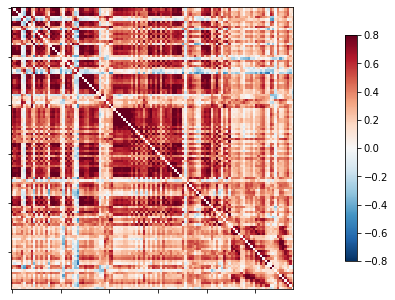

In [ ]:
np.fill_diagonal(fc, 0)
fig_fc, ax_fc = plt.subplots()
fc_display = plotting.plot_matrix(fc, figure=fig_fc, colorbar=True, vmax=0.8, vmin=-0.8)
fig_fc.patch.set_color("white")

In [20]:
inertias = []
states_list = []
scs = []
chs = []
dbs = []
ks = list(range(2, 15))
fcs2d = fcs.reshape((fcs.shape[0], 13456))
for k in ks:
    center, states, inertia = cluster.k_means(fcs2d, k)
    states_list.append(states)
    inertias.append(inertia)
    scs.append(metrics.silhouette_score(fcs2d, states))
    chs.append(metrics.calinski_harabasz_score(fcs2d, states))
    dbs.append(metrics.davies_bouldin_score(fcs2d, states))

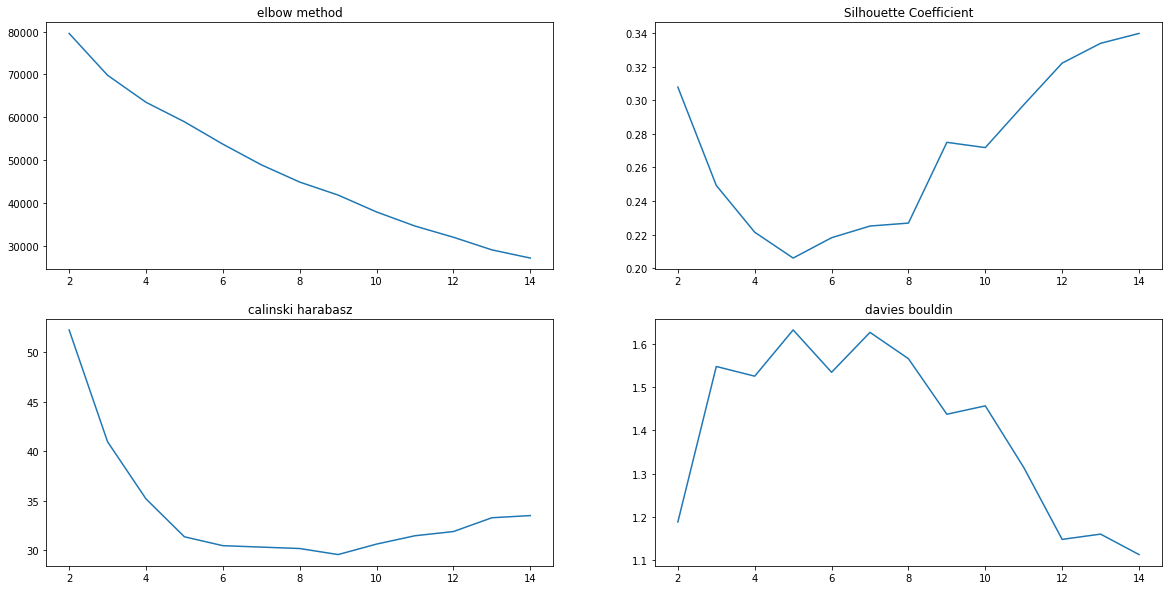

In [27]:
figi, axi = plt.subplots(2, 2, figsize=(20, 10))
figi.patch.set_color("white")
axi[0, 0].set_title("elbow method")
axi[0, 0].plot(ks, inertias)
axi[0, 1].set_title("Silhouette Coefficient")
axi[0, 1].plot(ks, scs)
axi[1, 0].set_title("calinski harabasz")
axi[1, 0].plot(ks, chs)
axi[1, 1].set_title("davies bouldin")
axi[1, 1].plot(ks, dbs)

In [29]:
center.shape

(10, 13456)

In [30]:
x = [0] * len(states) * 2
y = [0] * len(states) * 2
for i in range(1, len(states)):
    x[2*i-1] = x[2*i] = i
    y[2*i] = y[2*i+1] = states[i]
x[-1] = len(states)
y[0] = y[1] = states[0]

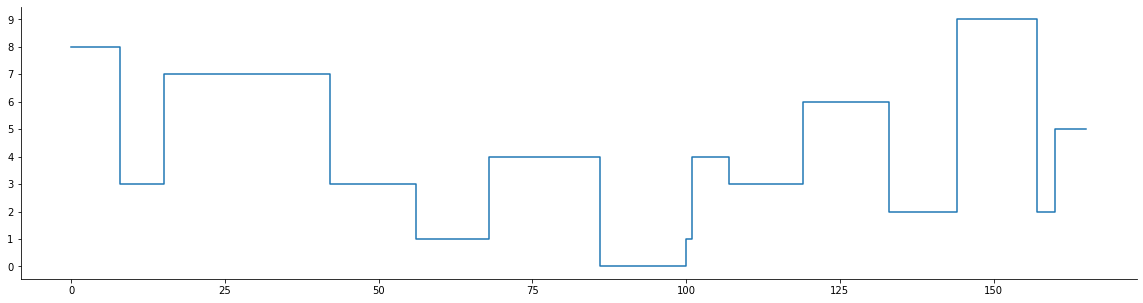

In [31]:
fig, ax = plt.subplots(figsize=(20, 5))
fig.patch.set_color("white")
# ax.tick_params(axis="x", colors="white")
# ax.tick_params(axis="y", colors="white")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.yaxis.set_major_formatter("{:>10d}")
ax.yaxis.set_major_locator(MaxNLocator(15, integer=True))
ax.plot(x,y)